In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2023-11-17 16:04:31.669941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:04:31.700131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 16:04:31.700155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 16:04:31.700180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 16:04:31.705770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:04:31.706330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Data aquisition&preparation

In [ ]:
# Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
dataset_name = "oxford_iiit_pet"  # dataset name
split = [
    "train[:60%]+test[:60%]",
    "train[60%:80%]+test[60%:80%]",
    "train[80%:]+test[80%:]",
]  # train-validation-test split

In [2]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102"  # dataset name
split = [
    "train[:60%]+validation[:60%]+test[:60%]",
    "train[60%:80%]+validation[60%:80%]+test[60%:80%]",
    "train[80%:]+validation[80%:]+test[80%:]",
]  # train-validation-test split

In [3]:
# Hyperparameters
IMAGE_SIZE = 64  # resized image size
BATCH_SIZE = 64  # batch size
TIMESTEPS = 500  # number of timesteps (noise levels)

LATENT_DIMENSION = 64  # latent dimension
LEARNING_RATE = 1e-3  # learning rate
EPOCHS = 1  # number of epochs (TODO change to a larger number)

In [4]:
# preprocess an image
def preprocess_image(data):
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)  # find the smallest dimension
    img = tf.image.crop_to_bounding_box(  # crop the image to a square
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    img = tf.cast(img, dtype=tf.float32)  # cast the image to float32
    img = tf.image.resize(img, size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True)  # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0, -1.0, 1.0)  # normalize the image to [-1, 1]


def reverse_transform(img):
    return tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0).numpy().astype(np.uint8)  # reverse the normalization

In [5]:
# preprocess a dataset
def preprocess_dataset(dataset):
    return (
        dataset.map( preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # preprocess images of the dataset
        .batch(BATCH_SIZE, drop_remainder=True)  # organize the dataset into batches
        .shuffle(2 * BATCH_SIZE)  # shuffle the dataset
        .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for better performance
    )


# load dataset from tensorflow datasets with the given name
def load_data(dataset_name):
    train_ds, val_ds, test_ds = tfds.load(dataset_name, split=split, shuffle_files=True)  # load the dataset
    train_ds = preprocess_dataset(train_ds)  # preprocess the training dataset
    val_ds = preprocess_dataset(val_ds)  # preprocess the validation dataset
    test_ds = preprocess_dataset(test_ds)  # preprocess the test dataset
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = load_data(dataset_name)

2023-11-17 16:04:45.259385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 16:04:45.259877: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
demo_img = next(iter(train_ds.unbatch().take(1)))

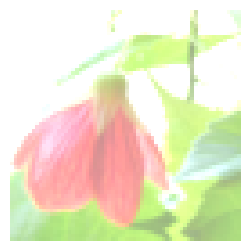

In [8]:
def show(img):
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img))
    plt.axis("off")
    plt.show()


def plot(imgs):
    _, axs = plt.subplots(figsize=(len(imgs) * 2, 2), ncols=len(imgs), nrows=1)
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()


show(demo_img)

## Forward Diffusion Process 

In [9]:
class Diffusion:
    def __init__(self, timesteps=1000, min_beta=0.0001, max_beta=0.02):
        self.timesteps = timesteps  # number of timesteps (noise levels)
        self.min_beta = min_beta  # first beta
        self.max_beta = max_beta  # last beta

        self.betas = tf.linspace(min_beta, max_beta, timesteps)  # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas  # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas)  # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0)  # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.square(1.0 / self.alphas)  # reciprocals of squares of alphas
        self.sqrt_alphas_prod = tf.math.square(self.alphas_cum_prod)  # squares of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.square(1.0 - self.alphas_cum_prod)  # squares of 1 - cumulative product of alphas

        # posterior variance (Equation 6, 7)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod)

    def extract(self, series, t, x_shape):
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])

    def q_sample(self, x_start, t, noise=None):
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype)

        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise  # Equation 12

    def p_sample_step(self, model, x, t, t_index):
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        noise_pred = model.predict([x, t])
        # print(noise_pred)
        model_mean = recip_sqrt_alphas_t * (x - noise_pred * beta_t / sqrt_one_minus_alphas_prod_t)  # Equation 11

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype)  # sample noise from N(0, I)
            return model_mean + tf.math.square(posterior_variance_t) * noise  # Algorith 2, Line 4

    def p_sample_full(self, model, shape, img=None, timesteps=None):
        if timesteps is None:
            timesteps = self.timesteps
        if img is None:
            img = tf.random.normal(shape, dtype=tf.float32)  # pure noise initially
        imgs = [img]
        for t in reversed(range(timesteps)):
            t_batch = tf.fill((shape[0],), t)
            img = self.p_sample_step(model, img, t_batch, t)
            imgs.append(img)
        return imgs

    def generate_image(self, model, image_size=IMAGE_SIZE):
        return self.p_sample_full(model, (1, image_size, image_size, 3))

In [10]:
forward_diffusion = Diffusion(TIMESTEPS)

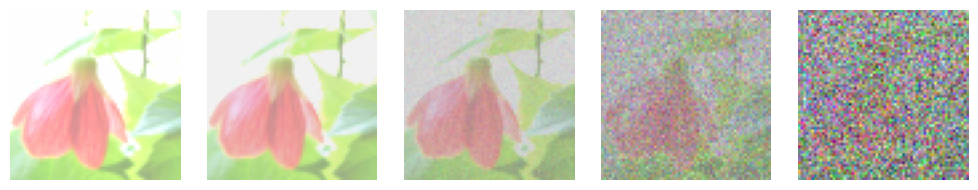

In [11]:
noisy_images = [
    tf.squeeze(
        forward_diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t]))
    )
    for t in [0, 50, 100, 150, 200]
]
plot(noisy_images)

## Neural network

A basic autoencoder for milestone 2

In [12]:
FILTERS = 16
DEPTH = 4


def residual_block(x: tf.Tensor, depth: int, filters: int) -> tf.Tensor:
    x = tf.keras.layers.Conv2D(
        filters,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(x)
    x = tf.keras.layers.Conv2D(
        filters,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(x)
    if depth == 0:
        return x
    y = tf.keras.layers.MaxPooling2D((2, 2))(x)
    y = residual_block(y, depth - 1, filters * 2)
    y = tf.keras.layers.UpSampling2D((2, 2))(y)
    # I don't know how to crop so I use Conv2D to halve the number of channels
    y = tf.keras.layers.Conv2D(
        filters,
        (1, 1),
    )(y)
    x = tf.keras.layers.add([x, y])
    x = tf.keras.layers.Conv2D(
        filters,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(x)
    x = tf.keras.layers.Conv2D(
        filters,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(x)
    return x


def create_u_net() -> tf.keras.Model:
    image_input = tf.keras.layers.Input(
        shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    time_input = tf.keras.layers.Input(
        shape=(1, 1, 1),
    )
    time_input = tf.keras.layers.Lambda(
        lambda x: tf.tile(x, [1, IMAGE_SIZE, IMAGE_SIZE, 1]),
    )(time_input)
    print(f"image_input.shape: {image_input.shape}")
    print(f"time_input.shape: {time_input.shape}")
    input_layer = tf.keras.layers.concatenate(
        [image_input, time_input],
    )
    print(f"input_layer.shape: {input_layer.shape}")
    residual_blocks = residual_block(input_layer, DEPTH, FILTERS)
    output_layer = tf.keras.layers.Conv2D(
        3,
        (1, 1),
        activation=tf.keras.activations.sigmoid,
    )(residual_blocks)
    u_net = tf.keras.Model([image_input, time_input], output_layer)
    return u_net


network = create_u_net()

image_input.shape: (None, 64, 64, 3)
time_input.shape: (None, 64, 64, 1)
input_layer.shape: (None, 64, 64, 4)


In [ ]:
def build_network(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=64):
    image_input = tf.keras.layers.Input(shape=input_shape)
    time_input = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Flatten()(image_input)
    combined = tf.keras.layers.Concatenate()([x, time_input])

    x = tf.keras.layers.Dense(latent_dim, activation="relu")(combined)  # encoder
    x = tf.keras.layers.Dense(np.prod(input_shape), activation="linear")(x)  # decoder
    x = tf.keras.layers.Reshape(input_shape)(x)

    return tf.keras.Model(inputs=[image_input, time_input], outputs=x, name="basic_autoencoder")


network = build_network(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIMENSION)

In [13]:
class DiffusionModel(tf.keras.Model):
    def __init__(self, diffusion, net):
        super().__init__()
        self.diffusion = diffusion
        self.network = net

    def call(self, Xs, training=None, mask=None):
        return self.network(Xs)

    def random_t(self, Xs):
        return tf.random.uniform(
            (tf.shape(Xs)[0],),
            minval=0,
            maxval=self.diffusion.timesteps,
            dtype=tf.int32,
        )

    def step(self, Xs, t):
        noise = tf.random.normal(tf.shape(Xs), dtype=Xs.dtype)
        Xs_noisy = self.diffusion.q_sample(Xs, t, noise)
        noise_pred = self.network([Xs_noisy, t], training=True)
        return self.loss(noise, noise_pred)

    def train_step(self, Xs):
        t = self.random_t(Xs)
        with tf.GradientTape() as tape:
            loss = self.step(Xs, t)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

    def test_step(self, Xs):
        t = self.random_t(Xs)
        return {"loss": self.step(Xs, t)}

In [14]:
model = DiffusionModel(diffusion=forward_diffusion, net=network)

In [15]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
)

In [16]:
model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_ds)

ValueError: in user code:

    File "/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_54934/1832309595.py", line 27, in train_step
        loss = self.step(Xs, t)
    File "/tmp/ipykernel_54934/1832309595.py", line 21, in step
        noise_pred = self.network([Xs_noisy, t], training=True)
    File "/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concatenate' (type Concatenate).
    
    Shape must be rank 4 but is rank 1 for '{{node model/concatenate/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](add, model/Cast, model/concatenate/concat/axis)' with input shapes: [64,64,64,3], [64], [].
    
    Call arguments received by layer 'concatenate' (type Concatenate):
      • inputs=['tf.Tensor(shape=(64, 64, 64, 3), dtype=float32)', 'tf.Tensor(shape=(64,), dtype=float32)']


# Evaluation

TODO: evaluate the model on the test set

In [ ]:
NUMBER_OF_IMAGES = 1
ROWS = 3
T = 1

original_images = next(iter(test_ds.unbatch().batch(NUMBER_OF_IMAGES)))
noisy_images = [
    forward_diffusion.q_sample(tf.expand_dims(img, 0), tf.constant([T]))
    for img in original_images
]
reconstructed_images = [
    forward_diffusion.p_sample_full(model, (1, IMAGE_SIZE, IMAGE_SIZE, 3), img, T)[-1]
    for img in noisy_images
]

In [ ]:
tf.random.normal((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32)

In [ ]:
plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 2 * ROWS))
for i in range(NUMBER_OF_IMAGES):
    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 0 * NUMBER_OF_IMAGES + 1)
    plt.imshow(tf.squeeze(noisy_images[i]))
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 1 * NUMBER_OF_IMAGES + 1)
    plt.imshow(tf.squeeze(reconstructed_images[i]))
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 2 * NUMBER_OF_IMAGES + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()

## Generate random images

In [ ]:
def generate_images(model, n=5):
    for _ in range(n):
        imgs = forward_diffusion.generate_image(model, IMAGE_SIZE)
        imgs = list(reversed(imgs[:: (len(imgs) // 5)]))
        plot([tf.squeeze(img) for img in imgs])

In [ ]:
generate_images(model)